<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments <br>
Prediction EnergyUse</font></b>

Ce notebook est la suite du notebook d'exploration des données Deveau_Estelle_1_notebook_exploratoire_022024

# Introduction

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
import time
from scipy.stats import uniform
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, loguniform

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/cleaned/")

['df_cleaned.csv']

In [4]:
path     = "./data/cleaned/"
filename = "df_cleaned.csv"

In [5]:
df = pd.read_csv(path + filename)
df.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,...,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
0,1.0,12,0,60.0,7456910.0,249.98,89,1,26.872820,52.917723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,1.0,11,15064,61.0,8664479.0,295.86,20,3,0.000000,37.426959,...,0.0,4622.0,0.0,0.0,15064.0,0.0,0.0,0.0,5.689886,15.974742
2,1.0,41,196718,43.0,73937112.0,2089.28,47,1,29.168781,66.984851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725
3,1.0,10,0,56.0,6946800.5,286.43,90,1,31.877211,39.858983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.657494,15.753792
4,1.0,11,0,27.0,6062767.5,176.14,90,1,0.000000,46.368511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.171279,15.617677


In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
df = df[df['GFA_Hopital_Clinic'] == 0]
df['GFA_Residence'] = df['GFA_Residence'] + df['GFA_Hotel'] 
df['GFA_Entrepot'] = df['GFA_Entrepot'] + df['GFA_Self_storage'] + df['GFA_Centre_ditribution']
df['GFA_Services_public'] = df['GFA_Entrepot'] + df['GFA_Reunion']

 

#Suppression de la colonne GFA_Laboratoire_Hopital
df.drop(columns=['GFA_Hopital_Clinic', 'GFA_Hotel', 'GFA_Self_storage', 'GFA_Centre_ditribution', 'GFA_Reunion'], inplace=True)



In [8]:
df.shape

(1121, 31)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1121 entries, 0 to 1132
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         1121 non-null   float64
 1   NumberofFloors            1121 non-null   int64  
 2   PropertyGFAParking        1121 non-null   int64  
 3   ENERGYSTARScore           720 non-null    float64
 4   SiteEnergyUseWN(kBtu)     1121 non-null   float64
 5   TotalGHGEmissions         1121 non-null   float64
 6   BuildingAge               1121 non-null   int64  
 7   NumberOfPropertyUseTypes  1121 non-null   int64  
 8   SteamUse_pct              1121 non-null   float64
 9   Electricity_pct           1121 non-null   float64
 10  NaturalGas_pct            1121 non-null   float64
 11  GFA_Loisir                1121 non-null   float64
 12  GFA_Commerce              1121 non-null   float64
 13  GFA_Services_public       1121 non-null   float64
 14  GFA_Autres   

In [10]:
df.describe()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
count,1121.000000,1121.000000,1121.000000,720.000000,1.121000e+03,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1.121000e+03,1121.000000,1121.000000,1121.000000,1.121000e+03,1.121000e+03,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,1.139161,3.867083,6819.468332,62.341667,6.390161e+06,133.270116,57.398751,1.851918,1.809708,66.055868,26.899061,4.925769e+03,7417.810169,12215.407672,7836.084300,4.579638e+03,3.493463e+04,2617.057092,1585.329170,2264.721677,11994.209634,1616.458519,811.098127,1410.524532,954.171276,7060.917038,409.726137,299.148974,7247.523640,3.857590,14.848536
std,1.292938,6.143754,28894.532907,28.614360,1.166456e+07,296.673597,31.980976,1.176943,8.185927,26.858329,23.828618,6.194076e+04,36431.187701,31199.380485,36277.756875,6.143666e+04,1.197540e+05,19024.873035,23965.936305,18466.996406,31187.363322,7623.728139,4819.900369,8400.148391,10586.333233,33035.346185,4634.863225,4769.506660,43154.050672,1.463367,1.232689
min,1.000000,1.000000,0.000000,1.000000,5.811420e+04,0.400000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.916291,10.970165
25%,1.000000,1.000000,0.000000,43.000000,1.213910e+06,19.070000,33.000000,1.000000,0.000000,44.308984,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.948116,14.009357
50%,1.000000,2.000000,0.000000,69.000000,2.447326e+06,46.260000,54.000000,1.000000,0.000000,65.086278,26.072621,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.834278,14.710506
75%,1.000000,4.000000,0.000000,86.250000,6.345882e+06,127.290000,88.000000,2.000000,0.000000,94.843060,46.663515,0.000000e+00,0.000000,9000.000000,1367.000000,0.000000e+00,2.302200e+04,0.000000,0.000000,0.000000,6792.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.846468,15.663317
max,27.000000,76.000000,327680.000000,100.000000,1.371061e+08,3995.450000,116.000000,9.000000,64.773098,100.000000,97.077764,1.585960e+06,561684.000000,371731.000000,535947.000000,1.719643e+06,1.680937e+06,367884.000000,726000.000000,281598.000000,371731.000000,103000.000000,80000.000000,121087.000000,181930.000000,438756.000000,100000.000000,142901.000000,756493.000000,8.292911,18.736266


Dans un premier temps, nous allons travailler en excluant l'ENERGYSTARScore puis nous ferons une comparaison avec son utilisation.

# Modelisation sans l'Energy Star Score

## Importance des features

### Data preparation

On supprime NaturalGas_pct car déductibles des autres features.

In [11]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore'], axis=1)
target = df['Log_SiteEnergyUseWN']

In [12]:
features.head(1)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
0,1.0,12,0,89,1,26.87282,52.917723,17.11772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0


### Séparation des données

In [13]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((896, 26), (225, 26))

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896 entries, 361 to 869
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         896 non-null    float64
 1   NumberofFloors            896 non-null    int64  
 2   PropertyGFAParking        896 non-null    int64  
 3   BuildingAge               896 non-null    int64  
 4   NumberOfPropertyUseTypes  896 non-null    int64  
 5   SteamUse_pct              896 non-null    float64
 6   Electricity_pct           896 non-null    float64
 7   NaturalGas_pct            896 non-null    float64
 8   GFA_Loisir                896 non-null    float64
 9   GFA_Commerce              896 non-null    float64
 10  GFA_Services_public       896 non-null    float64
 11  GFA_Autres                896 non-null    float64
 12  GFA_Education_sup         896 non-null    float64
 13  GFA_Bureau                896 non-null    float64
 14  GFA_Educ_prim

In [15]:
X_train.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
361,1.0,2,0,64,4,0.0,43.086418,48.773113,0.0,4270.0,101752.0,1578.0,0.0,8068.0,0.0,0.0,0.0,101752.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377,1.0,5,112980,13,1,0.0,99.999990,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177748.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,1.0,3,48510,56,1,0.0,99.504949,0.495051,0.0,0.0,0.0,0.0,0.0,65434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,1.0,2,0,97,1,0.0,54.348878,37.840169,0.0,0.0,0.0,1925.0,0.0,23995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,1.0,3,0,95,2,0.0,100.000000,0.000000,25096.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4540.0


In [16]:
y_train.head()

361    15.163046
377    16.112209
395    16.699050
536    14.481204
471    13.442477
Name: Log_SiteEnergyUseWN, dtype: float64

### Standardisation

In [17]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [18]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
361,-0.088342,-0.304108,-0.232516,0.204044,1.925052,-0.233118,-0.866297,0.940109,-0.073825,-0.090599,2.928384,-0.165965,-0.066757,-0.231239,-0.127781,-0.074064,-0.119760,2.936976,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
377,-0.088342,0.229819,3.894073,-1.415267,-0.731282,-0.233118,1.261375,-1.117861,-0.073825,-0.207816,-0.415134,-0.208042,-0.066757,-0.310810,-0.127781,-0.074064,10.538078,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
395,-0.088342,-0.126132,1.539310,-0.049966,-0.731282,-0.233118,1.242868,-1.096973,-0.073825,-0.207816,-0.415134,-0.208042,-0.066757,0.334535,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
536,-0.088342,-0.304108,-0.232516,1.251833,-0.731282,-0.233118,-0.445259,0.478796,-0.073825,-0.207816,-0.415134,-0.156713,-0.066757,-0.074158,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
471,-0.088342,-0.126132,-0.232516,1.188331,0.154162,-0.233118,1.261376,-1.117861,0.366505,-0.207816,-0.415134,-0.208042,-0.066757,-0.310810,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.058492


### Test de Student

In [19]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     Log_SiteEnergyUseWN   R-squared:                       0.590
Model:                             OLS   Adj. R-squared:                  0.578
Method:                  Least Squares   F-statistic:                     48.16
Date:                 Sun, 25 Feb 2024   Prob (F-statistic):          8.41e-149
Time:                         20:52:41   Log-Likelihood:                -1056.9
No. Observations:                  896   AIC:                             2168.
Df Residuals:                      869   BIC:                             2297.
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [20]:
# Suppression du NumberofFloors
X_train_scaled_df.drop(columns=['PropertyGFAParking'], inplace=True)

In [21]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     Log_SiteEnergyUseWN   R-squared:                       0.590
Model:                             OLS   Adj. R-squared:                  0.578
Method:                  Least Squares   F-statistic:                     50.12
Date:                 Sun, 25 Feb 2024   Prob (F-statistic):          1.35e-149
Time:                         20:52:41   Log-Likelihood:                -1057.1
No. Observations:                  896   AIC:                             2166.
Df Residuals:                      870   BIC:                             2291.
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [22]:
# Suppression du NumberofFloors
X_train_scaled_df.drop(columns=['NumberOfPropertyUseTypes'], inplace=True)

In [23]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     Log_SiteEnergyUseWN   R-squared:                       0.587
Model:                             OLS   Adj. R-squared:                  0.576
Method:                  Least Squares   F-statistic:                     51.60
Date:                 Sun, 25 Feb 2024   Prob (F-statistic):          4.69e-149
Time:                         20:52:41   Log-Likelihood:                -1060.5
No. Observations:                  896   AIC:                             2171.
Df Residuals:                      871   BIC:                             2291.
Df Model:                           24                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

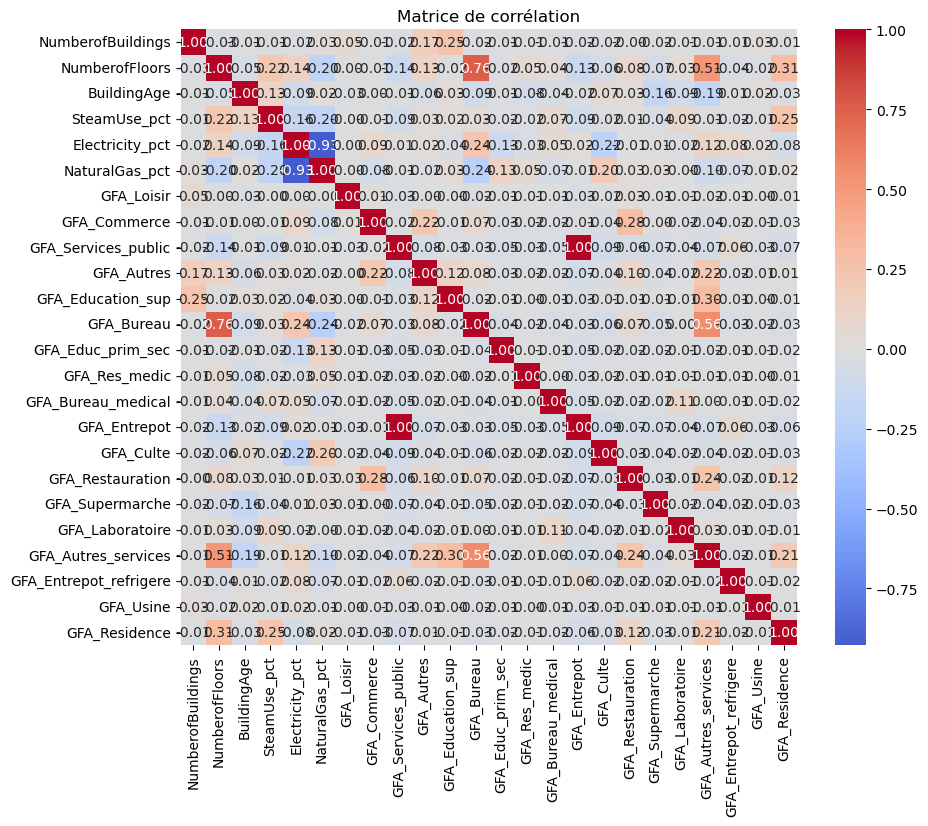

In [24]:
# Calcul de la matrice de corrélation
corr_matrix = X_train_scaled_df.corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, center=0)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

## Tests de modèles

### Data preparation

In [25]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore', 
                    'NumberOfPropertyUseTypes', 'PropertyGFAParking', 'NumberofBuildings'], axis=1)
#   , 'NumberofFloors'
target = df['Log_SiteEnergyUseWN']

# Transformation des variables catégorielles en variables numériques (encodage one-hot)
features = pd.get_dummies(features)

In [26]:
features.head(1)

,NumberofFloors,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
0,12,89,26.87282,52.917723,17.11772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0


In [27]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((896, 23), (225, 23))

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896 entries, 361 to 869
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NumberofFloors          896 non-null    int64  
 1   BuildingAge             896 non-null    int64  
 2   SteamUse_pct            896 non-null    float64
 3   Electricity_pct         896 non-null    float64
 4   NaturalGas_pct          896 non-null    float64
 5   GFA_Loisir              896 non-null    float64
 6   GFA_Commerce            896 non-null    float64
 7   GFA_Services_public     896 non-null    float64
 8   GFA_Autres              896 non-null    float64
 9   GFA_Education_sup       896 non-null    float64
 10  GFA_Bureau              896 non-null    float64
 11  GFA_Educ_prim_sec       896 non-null    float64
 12  GFA_Res_medic           896 non-null    float64
 13  GFA_Bureau_medical      896 non-null    float64
 14  GFA_Entrepot            896 non-null    float

In [29]:
X_train.head()

,NumberofFloors,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
361,2,64,0.0,43.086418,48.773113,0.0,4270.0,101752.0,1578.0,0.0,8068.0,0.0,0.0,0.0,101752.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377,5,13,0.0,99.999990,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177748.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,3,56,0.0,99.504949,0.495051,0.0,0.0,0.0,0.0,0.0,65434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,2,97,0.0,54.348878,37.840169,0.0,0.0,0.0,1925.0,0.0,23995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,3,95,0.0,100.000000,0.000000,25096.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4540.0


### Standardisation

In [30]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [31]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofFloors,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence
361,-0.304108,0.204044,-0.233118,-0.866297,0.940109,-0.073825,-0.090599,2.928384,-0.165965,-0.066757,-0.231239,-0.127781,-0.074064,-0.119760,2.936976,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
377,0.229819,-1.415267,-0.233118,1.261375,-1.117861,-0.073825,-0.207816,-0.415134,-0.208042,-0.066757,-0.310810,-0.127781,-0.074064,10.538078,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
395,-0.126132,-0.049966,-0.233118,1.242868,-1.096973,-0.073825,-0.207816,-0.415134,-0.208042,-0.066757,0.334535,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
536,-0.304108,1.251833,-0.233118,-0.445259,0.478796,-0.073825,-0.207816,-0.415134,-0.156713,-0.066757,-0.074158,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.160449
471,-0.126132,1.188331,-0.233118,1.261376,-1.117861,0.366505,-0.207816,-0.415134,-0.208042,-0.066757,-0.310810,-0.127781,-0.074064,-0.119760,-0.408377,-0.209541,-0.161796,-0.180387,-0.09091,-0.210385,-0.095198,-0.062024,-0.058492


### Test globale

In [32]:
# Liste de modèles à évaluer
models = [
    ('DummyRegressorMedian', DummyRegressor(strategy='median')),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet(random_state=0)),
    ('RandomForest', RandomForestRegressor(random_state=0)),
    ('GradientBoostingReg', GradientBoostingRegressor(random_state=0)),
    ('XGBoostReg', XGBRegressor(random_state=0)),
    ('SVR', SVR()),
    ('AdaBoostReg', AdaBoostRegressor(random_state=0))
]

# Tableau pour collecter les résultats
results = []

# Évaluer chaque modèle
for name, model in models:
    # Entraîner le modèle
    start_time = time.time() 
    model.fit(X_train_scaled, y_train)
    end_time = time.time()  # Enregistre le temps de fin
    duration = end_time - start_time  # Calcule la durée
    
    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # RMSE CV
    scores_rmse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-scores_rmse).mean()
    
    # R2 CV
    scores_r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_cv = scores_r2.mean()
    r2_cv_std = scores_r2.std() 
    
    results.append((name, rmse, mae, r2, rmse_cv, r2_cv, r2_cv_std, duration))


In [33]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=['Modèle', 'RMSE', 'MAE', 'R2', 'RMSE CV', 'R2 CV', 'R2 CV Std', 'Temps de calcul'])
df_sorted_by_performance = df_results.sort_values(by=['R2 CV'], ascending=[False])

df_sorted_by_performance

,Modèle,RMSE,MAE,R2,RMSE CV,R2 CV,R2 CV Std,Temps de calcul
8,SVR,0.652851,0.490349,0.719921,0.668701,0.701078,0.041334,0.029533
5,RandomForest,0.673485,0.497416,0.701937,0.696386,0.677059,0.035409,0.751360
6,GradientBoostingReg,0.690685,0.528291,0.686518,0.709452,0.663408,0.048916,0.205106
7,XGBoostReg,0.702223,0.537199,0.675957,0.709687,0.661716,0.063790,0.307989
9,AdaBoostReg,0.919979,0.710929,0.443829,0.909766,0.449783,0.039153,0.088478
1,LinearRegression,0.850461,0.631461,0.524708,0.941508,0.411307,0.085348,0.000000
2,Ridge,0.850376,0.632852,0.524802,0.943111,0.409633,0.076094,0.001002
4,ElasticNet,1.216632,0.956592,0.027318,1.216305,0.020341,0.010974,0.001013
3,Lasso,1.243288,0.972295,-0.015770,1.228912,-0.000320,0.000309,0.000000
0,DummyRegressorMedian,1.266253,0.978380,-0.053641,1.236269,-0.012403,0.004106,0.001001


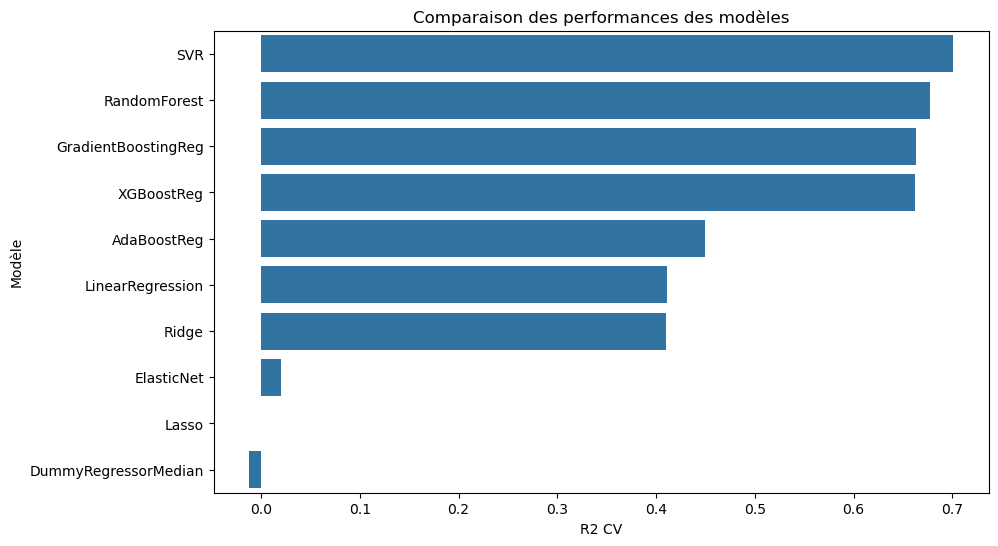

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 CV', y='Modèle', data=df_sorted_by_performance)
plt.title('Comparaison des performances des modèles')
plt.show()

Les modèles Ridge, Lasso, LinearRegression sont les 3 meilleurs modèles avec des performances assez similaires. Nous allons etudier chacun d'eux pour voir lequel sera le meilleur une fois les hyperparamètres trouvés.

## Regression Ridge

## Linear Regression

## Random Forest

## SVR

### Le modèle de base

In [35]:
# Créer le modèle SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Entraîner le modèle sur les données d'entraînement mises à l'échelle
svr_model.fit(X_train_scaled, y_train)

# Prédire sur l'ensemble de test mis à l'échelle
y_pred_svr = svr_model.predict(X_test_scaled)

# Calculer les métriques pour le modèle SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_svr - y_test) / (np.abs(y_pred_svr) + np.abs(y_test)))

print("Métriques pour le modèle SVR :")
print("RMSE: {:.2f}".format(rmse_svr))
print("MAE: {:.2f}".format(mae_svr))
print("R2: {:.2f}".format(r2_svr))
print("SMAPE: {:.2f}%".format(smape_svr))

Métriques pour le modèle SVR :
RMSE: 0.65
MAE: 0.49
R2: 0.72
SMAPE: 3.31%


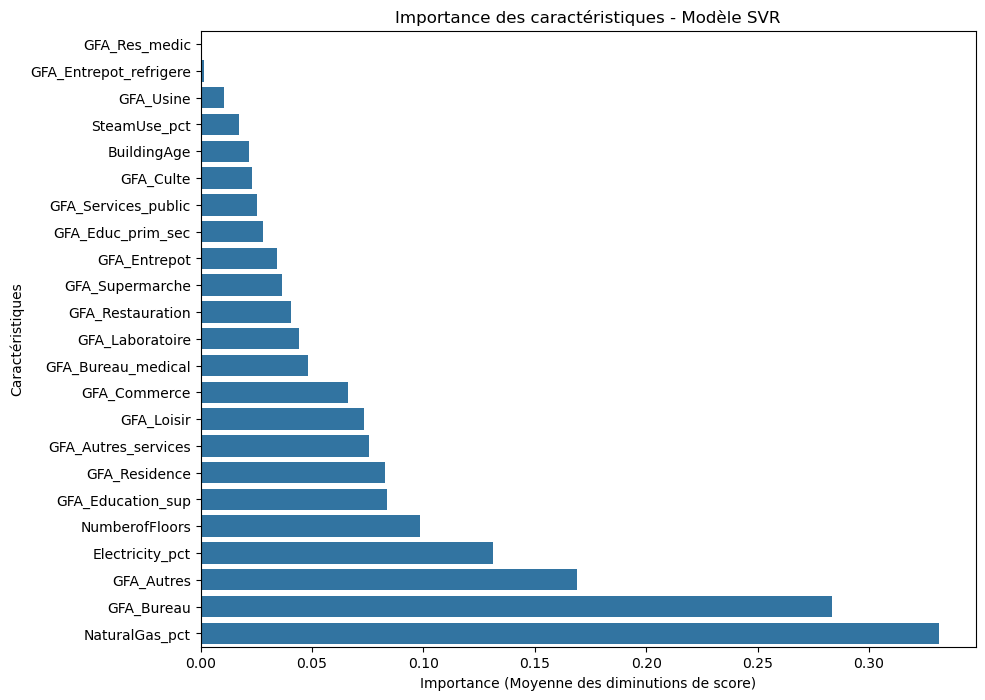

In [36]:
# Calculer l'importance des caractéristiques par permutation
perm_importance = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=30, random_state=0)

# Créer un DataFrame pour stocker les features et leur importance
features_svr = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})

# Tri des caractéristiques par importance décroissante
features_svr = features_svr.sort_values('Importance', ascending=True)

# Création du graphique
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=features_svr)
plt.title('Importance des caractéristiques - Modèle SVR')
plt.xlabel('Importance (Moyenne des diminutions de score)')
plt.ylabel('Caractéristiques')
plt.show()

### Recherche des hyperparamètres

In [37]:
# Définition de l'espace des hyperparamètres pour RandomizedSearchCV
param_distributions = {
    'C': loguniform(1e-3, 1e3), 
    'epsilon': uniform(0.01, 1), 
    'gamma': loguniform(1e-4, 1e-1) 
}

# Création de l'objet RandomizedSearchCV pour une SVR
random_search_svr = RandomizedSearchCV(estimator=SVR(kernel='rbf'), 
                                        param_distributions=param_distributions,
                                        n_iter=100,  
                                        scoring='neg_mean_squared_error',  
                                        cv=5,  
                                        random_state=0, 
                                        verbose=1)  

# Exécution de la recherche aléatoire
random_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR: ", random_search_svr.best_params_)
meilleur_score_rmse_svr = np.sqrt(-random_search_svr.best_score_) 
print("Meilleur score (RMSE) pour SVR: ", meilleur_score_rmse_svr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR:  {'C': 8.177482436211173, 'epsilon': 0.44141843543397397, 'gamma': 0.04893727555349513}
Meilleur score (RMSE) pour SVR:  0.6381958638346406


In [38]:
# Définition de la grille d'hyperparamètres à explorer
param_grid_svr = {
    'C': np.linspace(start=max(0.1, 4.935798091294871 - 1), stop=4.935798091294871 + 1, num=10),
    'epsilon': np.linspace(start=max(0.01, 0.13381998284944152 - 0.05), stop=0.13381998284944152 + 0.05, num=10),
    'gamma': np.linspace(start=max(1e-5, 0.0349965060627184 - 0.01), stop=0.0349965060627184 + 0.01, num=10)
}

# Création de l'objet GridSearchCV pour une SVR
grid_search_svr = GridSearchCV(estimator=SVR(kernel='rbf'), 
                               param_grid=param_grid_svr, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               n_jobs=-1, 
                               verbose=1)

# Exécution de la recherche par grille sur l'ensemble d'entraînement
grid_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour SVR: ", grid_search_svr.best_params_)

# Calcul de la RMSE sur l'ensemble de test avec le meilleur modèle trouvé
y_pred_gs_svr = grid_search_svr.best_estimator_.predict(X_test_scaled)
rmse_gs_svr = np.sqrt(mean_squared_error(y_test, y_pred_gs_svr))
mae_gs_svr = mean_absolute_error(y_test, y_pred_gs_svr)
r2_gs_svr = r2_score(y_test, y_pred_gs_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_gs_svr - y_test) / (np.abs(y_pred_gs_svr) + np.abs(y_test)))

print("RMSE avec GridSearchCV pour SVR: {:.4f}".format(rmse_gs_svr))
print("MAE avec GridSearchCV pour SVR: {:.4f}".format(mae_gs_svr))
print("R2 avec GridSearchCV pour SVR: {:.4f}".format(r2_gs_svr))
print("SMAPE avec GridSearchCV pour SVR: {:.4f}%".format(smape_svr))


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Meilleurs hyperparamètres pour SVR:  {'C': 5.935798091294871, 'epsilon': 0.1838199828494415, 'gamma': 0.0449965060627184}
RMSE avec GridSearchCV pour SVR: 0.6190
MAE avec GridSearchCV pour SVR: 0.4497
R2 avec GridSearchCV pour SVR: 0.7482
SMAPE avec GridSearchCV pour SVR: 3.0252%


In [39]:
# Meilleurs hyperparamètres obtenus de GridSearchCV pour SVR
best_params_svr = grid_search_svr.best_params_

# Configuration du modèle SVR avec les meilleurs hyperparamètres
best_svr_model = SVR(**best_params_svr)

# Métriques à évaluer lors de la validation croisée
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Exécution de la validation croisée (5 plis)
cv_results_svr = cross_validate(best_svr_model, X_train_scaled, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Calcul et affichage des métriques moyennes pour chaque pli
rmse_scores_svr = np.sqrt(-cv_results_svr['test_neg_mean_squared_error'])
mae_scores_svr = -cv_results_svr['test_neg_mean_absolute_error']
r2_scores_svr = cv_results_svr['test_r2']

# Affichage avec écart type
print(f"Validation Croisée RMSE pour SVR: {rmse_scores_svr.mean():.4f} (± {rmse_scores_svr.std():.4f})")
print(f"Validation Croisée MAE pour SVR: {mae_scores_svr.mean():.4f} (± {mae_scores_svr.std():.4f})")
print(f"Validation Croisée R² pour SVR: {r2_scores_svr.mean():.4f} (± {r2_scores_svr.std():.4f})")

Validation Croisée RMSE pour SVR: 0.6332 (± 0.0362)
Validation Croisée MAE pour SVR: 0.4764 (± 0.0188)
Validation Croisée R² pour SVR: 0.7320 (± 0.0389)


In [40]:
best_svr_model.fit(X_train_scaled, y_train) 

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_svr_model.predict(X_train_scaled)

# Prédictions sur l'ensemble de test
y_test_pred = best_svr_model.predict(X_test_scaled)

# Calcul des métriques pour l'ensemble d'entraînement
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_smape = 100 * np.mean(2 * np.abs(y_train_pred - y_train) / (np.abs(y_train_pred) + np.abs(y_train)))

# Calcul des métriques pour l'ensemble de test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_smape = 100 * np.mean(2 * np.abs(y_test_pred - y_test) / (np.abs(y_test_pred) + np.abs(y_test)))

# Affichage des métriques
print("Ensemble d'entraînement : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(train_rmse, train_r2, train_mae, train_smape))
print("Ensemble de test : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(test_rmse, test_r2, test_mae, test_smape))


Ensemble d'entraînement : RMSE = 0.51, R² = 0.83, MAE = 0.37, SMAPE = 2.53%
Ensemble de test : RMSE = 0.62, R² = 0.75, MAE = 0.45, SMAPE = 3.03%


## Analyse des erreurs

### Avec les cibles en log

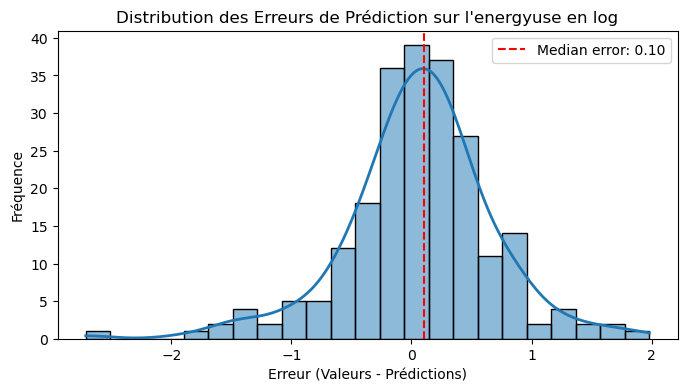

In [41]:
# Calcul des erreurs
errors = y_test - y_test_pred

# Calcul de l'erreur moyenne
med_error = np.median(errors)

# Visualisation de la distribution des erreurs
# Couleurs de la palette tab10
colors_tab10 = plt.cm.tab10(np.arange(10))
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, color=colors_tab10[0], line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(med_error, color='red', linestyle='--', label=f'Median error: {med_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction sur l\'energyuse en log')
plt.xlabel('Erreur (Valeurs - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

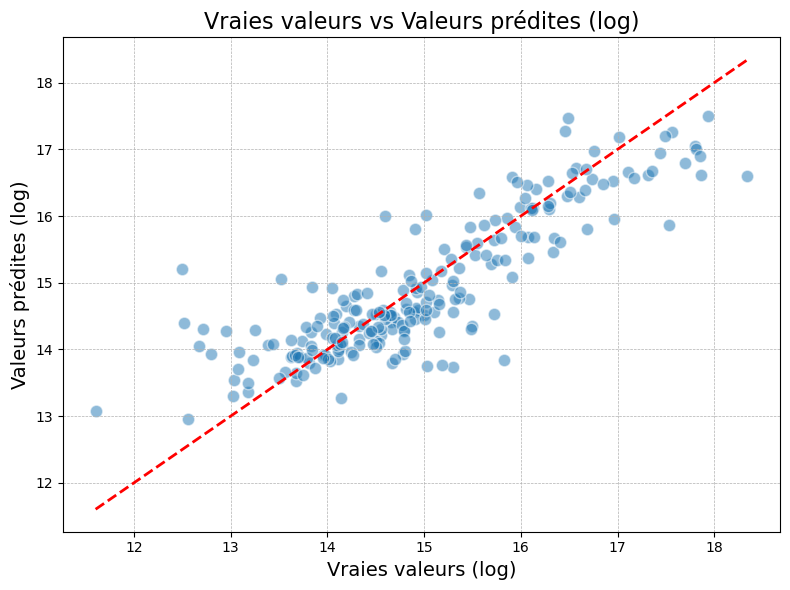

In [42]:
plt.figure(figsize=(8, 6))  # Augmenter la taille du graphique
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='w', s=80)  # Ajouter des bords blancs pour mieux distinguer les points superposés
plt.title('Vraies valeurs vs Valeurs prédites (log)', fontsize=16)
plt.xlabel('Vraies valeurs (log)', fontsize=14)
plt.ylabel('Valeurs prédites (log)', fontsize=14)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Grille plus fine
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)  # Grille mineure
plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour bien remplir la figure
plt.show()


### Avec les valeurs réelles

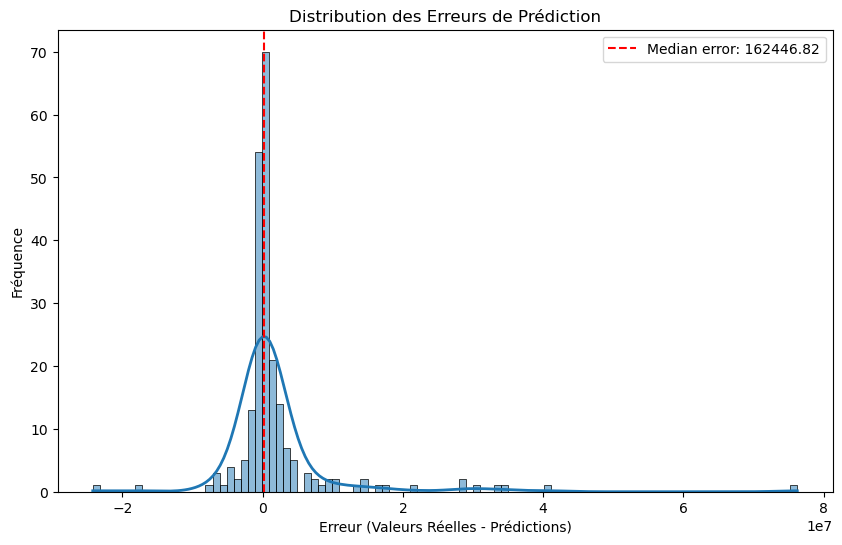

In [43]:
# Conversion des prédictions et des valeurs réelles de test de log à l'échelle originale
y_test_pred_original = np.exp(y_test_pred) 
y_test_original = np.exp(y_test)  

# Calcul des erreurs
errors = y_test_original - y_test_pred_original

# Calcul de l'erreur moyenne
med_error = np.median(errors)

# Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color=colors_tab10[0], binwidth=1000000, line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(med_error, color='red', linestyle='--', label=f'Median error: {med_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction')
plt.xlabel('Erreur (Valeurs Réelles - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

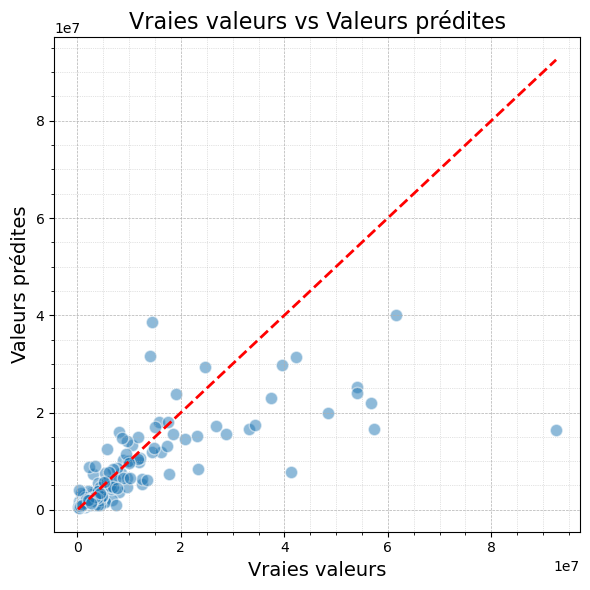

In [44]:
plt.figure(figsize=(6, 6)) 
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5, edgecolors='w', s=80)  
plt.title('Vraies valeurs vs Valeurs prédites', fontsize=16)
plt.xlabel('Vraies valeurs', fontsize=14)
plt.ylabel('Valeurs prédites', fontsize=14)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5) 
plt.minorticks_on() 
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7) 
plt.tight_layout() 
plt.show()

In [45]:
# Création d'un DataFrame avec les valeurs réelles et prédites
df_errors = pd.DataFrame({'Valeurs réelles': y_test_original, 'Valeurs prédites': y_test_pred_original})


# Calcul des erreurs absolues et ajout en tant que nouvelle colonne
df_errors['Erreurs absolues'] = abs(df_errors['Valeurs réelles'] - df_errors['Valeurs prédites'])

# Trier le DataFrame par les erreurs absolues de façon décroissante
df_errors_sorted = df_errors.sort_values('Erreurs absolues', ascending=False)

# Afficher les 15 erreurs les plus grandes
print(df_errors_sorted.head(15))

      Valeurs réelles  Valeurs prédites  Erreurs absolues
338        92537256.0      1.631008e+07      7.622718e+07
85         57406988.0      1.653729e+07      4.086970e+07
295        56785916.0      2.186870e+07      3.491722e+07
1085       41225944.0      7.802758e+06      3.342319e+07
88         54136068.0      2.411012e+07      3.002595e+07
161        53974556.0      2.524218e+07      2.873238e+07
144        48479988.0      1.980610e+07      2.867389e+07
171        14436982.0      3.866480e+07      2.422782e+07
99         61674856.0      4.009147e+07      2.158339e+07
142        14072349.0      3.159663e+07      1.752429e+07
10         34351920.0      1.734813e+07      1.700379e+07
443        33092532.0      1.655006e+07      1.654247e+07
955        23204450.0      8.471277e+06      1.473317e+07
69         37410800.0      2.296127e+07      1.444953e+07
63         28763498.0      1.562099e+07      1.314251e+07


In [46]:
indices_plus_gd_erreurs = df_errors_sorted.head(15).index
df_top_errors = df.loc[indices_plus_gd_erreurs]
df_top_errors

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Loisir,GFA_Commerce,GFA_Services_public,GFA_Autres,GFA_Education_sup,GFA_Bureau,GFA_Educ_prim_sec,GFA_Res_medic,GFA_Bureau_medical,GFA_Entrepot,GFA_Culte,GFA_Restauration,GFA_Supermarche,GFA_Laboratoire,GFA_Autres_services,GFA_Entrepot_refrigere,GFA_Usine,GFA_Residence,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
338,1.0,76,319400,86.0,92537256.0,882.56,31,2,0.000000,94.527767,5.472233,0.0,0.0,0.0,0.0,0.0,1680937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,319368.0,0.0,0.0,0.0,6.782827,18.343122
85,1.0,3,0,NaN,57406988.0,1246.55,17,1,0.000000,69.131180,30.868820,1172127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.128135,17.865677
295,1.0,42,0,97.0,56785916.0,481.06,11,5,1.737056,97.073232,0.684205,0.0,0.0,0.0,25384.0,0.0,1218742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348788.0,0.0,0.0,0.0,6.175992,17.854799
1085,1.0,4,0,NaN,41225944.0,537.03,11,2,0.000000,85.166916,13.348068,0.0,0.0,0.0,733.0,0.0,88698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72726.0,0.0,0.0,0.0,6.286054,17.534578
88,14.0,2,31874,NaN,54136068.0,748.55,36,4,0.000000,83.717528,15.045976,0.0,0.0,0.0,0.0,0.0,240984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72963.0,16766.0,0.0,0.0,0.0,6.618138,17.807011
161,1.0,30,134662,72.0,53974556.0,793.05,31,5,0.962287,80.037644,15.760841,0.0,0.0,0.0,0.0,0.0,643083.0,0.0,0.0,0.0,0.0,0.0,13422.0,0.0,0.0,126891.0,0.0,0.0,0.0,6.675886,17.804023
144,1.0,42,0,69.0,48479988.0,337.97,40,5,0.000000,99.999988,0.000000,0.0,0.0,0.0,0.0,0.0,718473.0,0.0,0.0,0.0,0.0,0.0,19671.0,0.0,0.0,40000.0,0.0,0.0,0.0,5.822957,17.696662
171,1.0,12,38000,NaN,14436982.0,100.65,31,1,0.000000,99.999993,0.000000,0.0,0.0,0.0,155500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.611649,16.485304
99,1.0,15,0,NaN,61674856.0,433.60,61,1,0.000000,100.000000,0.000000,0.0,0.0,0.0,203000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.072122,17.937387
142,1.0,8,0,76.0,14072349.0,355.05,89,3,26.297171,70.748359,0.000000,39355.0,19787.0,0.0,95884.0,0.0,166919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.872259,16.459722


# Modélisation avec l'Energy Star Score

# Comparaison et conclusion